In [69]:
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Doc
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
import nltk
nltk.download('opinion_lexicon')
nltk.download('punkt')
from collections import Counter
import ast
import matplotlib.pyplot as plt

# spacy.cli.download('en_core_web_sm')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/clarasmith/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/clarasmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("sentiment_df_analysis")

In [3]:
# Import Spacy's pipeline, disabling the resource intensive bits.
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # disable heavy pipeline parts for speed


In [4]:
# Quickly document some possible abbreviations
ABBR_MAP = {
    "si": "Supplemental Instruction",
    "prof": "instructor",
    "ta": "teaching assistant"
}

In [5]:
def normalize_text(text):
    text = text.lower()  # lowercase for consistent mapping
    # Replace abbreviations
    for abbr, full in ABBR_MAP.items():
        text = re.sub(rf"\b{abbr}\b", full.lower(), text)
    return text

In [6]:
def preprocess_text(text):
    text = normalize_text(text)
    doc = nlp(text)
    
    # Keep meaningful tokens: remove stopwords but keep punctuation if sentiment matters
    tokens = [
        token.lemma_ if token.lemma_ != "-PRON-" else token.text
        for token in doc
        if not token.is_stop and not token.is_space
    ]
    
    return tokens


In [7]:
def normalize_repeated_chars(text):
    return re.sub(r"(.)\1{2,}", r"\1\1", text)  # limit repeated characters to 2


In [8]:
processed_texts = []
for response in df['response']:  # survey_texts = list of student responses
    clean_text = normalize_repeated_chars(response)
    tokens = preprocess_text(clean_text)
    processed_texts.append(tokens)


In [9]:
# Apply preprocessing directly to the DataFrame column
df["processed_tokens"] = df["response"].apply(
    lambda x: preprocess_text(normalize_repeated_chars(x))
)


In [10]:
display(df)

,question_id,question_text,response,processed_tokens
0,Q12,How has working collaboratively with your SI c...,Working collaboratively with my SI classmates ...,"[work, collaboratively, supplemental, instruct..."
1,Q12,How has working collaboratively with your SI c...,It went well!,"[go, !]"
2,Q12,How has working collaboratively with your SI c...,It give me a better understanding of the subject.,"[well, understanding, subject, .]"
3,Q12,How has working collaboratively with your SI c...,I better remember the material,"[well, remember, material]"
4,Q12,How has working collaboratively with your SI c...,It meant that we were all able to help cover k...,"[mean, able, help, cover, knowledge, know, .]"
...,...,...,...,...
897,Q14,What suggestions do you have for improving the...,I think having more SI class times available w...,"[think, have, supplemental, instruction, class..."
898,Q14,What suggestions do you have for improving the...,nothing it is working great for me,"[work, great]"
899,Q14,What suggestions do you have for improving the...,Make the info more beneficial and go over more...,"[info, beneficial, practice, problem, ., make,..."
900,Q14,What suggestions do you have for improving the...,Nothing,[]


In [11]:
# Join tokens into a string for n-gram extraction
df["processed_text"] = df["processed_tokens"].apply(lambda x: " ".join(x))


In [12]:
display(df)

,question_id,question_text,response,processed_tokens,processed_text
0,Q12,How has working collaboratively with your SI c...,Working collaboratively with my SI classmates ...,"[work, collaboratively, supplemental, instruct...",work collaboratively supplemental instruction ...
1,Q12,How has working collaboratively with your SI c...,It went well!,"[go, !]",go !
2,Q12,How has working collaboratively with your SI c...,It give me a better understanding of the subject.,"[well, understanding, subject, .]",well understanding subject .
3,Q12,How has working collaboratively with your SI c...,I better remember the material,"[well, remember, material]",well remember material
4,Q12,How has working collaboratively with your SI c...,It meant that we were all able to help cover k...,"[mean, able, help, cover, knowledge, know, .]",mean able help cover knowledge know .
...,...,...,...,...,...
897,Q14,What suggestions do you have for improving the...,I think having more SI class times available w...,"[think, have, supplemental, instruction, class...",think have supplemental instruction class time...
898,Q14,What suggestions do you have for improving the...,nothing it is working great for me,"[work, great]",work great
899,Q14,What suggestions do you have for improving the...,Make the info more beneficial and go over more...,"[info, beneficial, practice, problem, ., make,...",info beneficial practice problem . make require .
900,Q14,What suggestions do you have for improving the...,Nothing,[],


In [13]:
from sklearn.feature_extraction.text import CountVectorizer


In [14]:
def get_ngrams_safe(text, ngram_range=(2,3)):
    if not text.strip():  # skip empty strings
        return []
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    try:
        X = vectorizer.fit_transform([text])
        return vectorizer.get_feature_names_out().tolist()
    except ValueError:
        return []  # return empty list if vocabulary is empty


In [15]:
df["ngrams"] = df["processed_text"].apply(lambda x: get_ngrams_safe(x))


In [16]:
display(df)

,question_id,question_text,response,processed_tokens,processed_text,ngrams
0,Q12,How has working collaboratively with your SI c...,Working collaboratively with my SI classmates ...,"[work, collaboratively, supplemental, instruct...",work collaboratively supplemental instruction ...,"[able talk, able talk concept, classmate help,..."
1,Q12,How has working collaboratively with your SI c...,It went well!,"[go, !]",go !,[]
2,Q12,How has working collaboratively with your SI c...,It give me a better understanding of the subject.,"[well, understanding, subject, .]",well understanding subject .,"[understanding subject, well understanding, we..."
3,Q12,How has working collaboratively with your SI c...,I better remember the material,"[well, remember, material]",well remember material,"[remember material, well remember, well rememb..."
4,Q12,How has working collaboratively with your SI c...,It meant that we were all able to help cover k...,"[mean, able, help, cover, knowledge, know, .]",mean able help cover knowledge know .,"[able help, able help cover, cover knowledge, ..."
...,...,...,...,...,...,...
897,Q14,What suggestions do you have for improving the...,I think having more SI class times available w...,"[think, have, supplemental, instruction, class...",think have supplemental instruction class time...,"[available beneficial, available beneficial pr..."
898,Q14,What suggestions do you have for improving the...,nothing it is working great for me,"[work, great]",work great,[work great]
899,Q14,What suggestions do you have for improving the...,Make the info more beneficial and go over more...,"[info, beneficial, practice, problem, ., make,...",info beneficial practice problem . make require .,"[beneficial practice, beneficial practice prob..."
900,Q14,What suggestions do you have for improving the...,Nothing,[],,[]


In [17]:
# Sentiment lexicon setup
pos_words = set(opinion_lexicon.positive())
neg_words = set(opinion_lexicon.negative())

In [19]:
def sentiment_counts(tokens):
    pos_count = sum(1 for t in tokens if t in pos_words)
    neg_count = sum(1 for t in tokens if t in neg_words)
    return pos_count, neg_count

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

def pos_words_extract(text):
    """Extract actual words by POS"""
    doc = nlp(text)
    return {
        "nouns": [token.lemma_.lower() for token in doc if token.pos_ == "NOUN"],
        "verbs": [token.lemma_.lower() for token in doc if token.pos_ == "VERB"],
        "adjectives": [token.lemma_.lower() for token in doc if token.pos_ == "ADJ"],
        "adverbs": [token.lemma_.lower() for token in doc if token.pos_ == "ADV"]
    }

In [20]:
df["processed_tokens"] = df["response"].apply(lambda x: preprocess_text(normalize_repeated_chars(x)))
df["processed_text"] = df["processed_tokens"].apply(lambda x: " ".join(x))
df["ngrams"] = df["processed_text"].apply(lambda x: get_ngrams_safe(x))
df["entities"] = df["response"].apply(extract_entities)
df["pos_tokens"] = df["processed_text"].apply(pos_words_extract)  
df["nouns"] = df["pos_tokens"].apply(lambda x: x["nouns"])
df["verbs"] = df["pos_tokens"].apply(lambda x: x["verbs"])
df["adjectives"] = df["pos_tokens"].apply(lambda x: x["adjectives"])
df["adverbs"] = df["pos_tokens"].apply(lambda x: x["adverbs"])

In [21]:
display(df)

,question_id,question_text,response,processed_tokens,processed_text,ngrams,entities,pos_tokens,nouns,verbs,adjectives,adverbs
0,Q12,How has working collaboratively with your SI c...,Working collaboratively with my SI classmates ...,"[work, collaboratively, supplemental, instruct...",work collaboratively supplemental instruction ...,"[able talk, able talk concept, classmate help,...",[],"{'nouns': ['instruction', 'classmate', 'help',...","[instruction, classmate, help, semester, talk,...","[work, simplify]","[supplemental, able]",[collaboratively]
1,Q12,How has working collaboratively with your SI c...,It went well!,"[go, !]",go !,[],[],"{'nouns': [], 'verbs': ['go'], 'adjectives': [...",[],[go],[],[]
2,Q12,How has working collaboratively with your SI c...,It give me a better understanding of the subject.,"[well, understanding, subject, .]",well understanding subject .,"[understanding subject, well understanding, we...",[],"{'nouns': ['subject'], 'verbs': ['understand']...",[subject],[understand],[],[]
3,Q12,How has working collaboratively with your SI c...,I better remember the material,"[well, remember, material]",well remember material,"[remember material, well remember, well rememb...",[],"{'nouns': ['material'], 'verbs': ['remember'],...",[material],[remember],[],[]
4,Q12,How has working collaboratively with your SI c...,It meant that we were all able to help cover k...,"[mean, able, help, cover, knowledge, know, .]",mean able help cover knowledge know .,"[able help, able help cover, cover knowledge, ...",[],"{'nouns': ['help', 'knowledge'], 'verbs': ['me...","[help, knowledge]","[mean, cover, know]",[able],[]
...,...,...,...,...,...,...,...,...,...,...,...,...
897,Q14,What suggestions do you have for improving the...,I think having more SI class times available w...,"[think, have, supplemental, instruction, class...",think have supplemental instruction class time...,"[available beneficial, available beneficial pr...",[],"{'nouns': ['instruction', 'class', 'time', 'pr...","[instruction, class, time, program]",[think],"[supplemental, available, beneficial]",[]
898,Q14,What suggestions do you have for improving the...,nothing it is working great for me,"[work, great]",work great,[work great],[],"{'nouns': [], 'verbs': ['work'], 'adjectives':...",[],[work],[great],[]
899,Q14,What suggestions do you have for improving the...,Make the info more beneficial and go over more...,"[info, beneficial, practice, problem, ., make,...",info beneficial practice problem . make require .,"[beneficial practice, beneficial practice prob...",[],"{'nouns': ['info', 'practice', 'problem', 'req...","[info, practice, problem, require]",[make],[beneficial],[]
900,Q14,What suggestions do you have for improving the...,Nothing,[],,[],[],"{'nouns': [], 'verbs': [], 'adjectives': [], '...",[],[],[],[]


In [22]:
df.columns

Index(['question_id', 'question_text', 'response', 'processed_tokens',
       'processed_text', 'ngrams', 'entities', 'pos_tokens', 'nouns', 'verbs',
       'adjectives', 'adverbs'],
      dtype='object')

In [23]:
def safe_parse_list(x):
    """Safely parse string representations of lists"""
    # Check if it's already a list or array
    if isinstance(x, (list, np.ndarray)):
        return list(x) if len(x) > 0 else []
    
    # Check for NaN or empty string
    if x is None or (isinstance(x, str) and x.strip() == ''):
        return []
    
    try:
        if pd.isna(x):
            return []
    except (ValueError, TypeError):
        pass
    
    # Try to parse string representation
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            return parsed if isinstance(parsed, list) else []
        except:
            return []
    
    return []

In [24]:
def create_question_overview(df):
    """Overview of responses per question"""
    overview = df.groupby('question_id').agg({
        'response': ['count', lambda x: x.notna().sum()],
        'processed_text': lambda x: x.str.split().str.len().mean()
    }).round(2)
    
    overview.columns = ['Total Responses', 'Valid Responses', 'Avg Words per Response']
    overview = overview.reset_index()
    overview['Response Rate %'] = (overview['Valid Responses'] / overview['Total Responses'] * 100).round(1)
    
    print("Question Overview")
    print(overview.to_string(index=False))
    print("\n")
    
    return overview

In [25]:
create_question_overview(df)

Question Overview
question_id  Total Responses  Valid Responses  Avg Words per Response  Response Rate %
        Q12              342              342                    8.03            100.0
        Q13              289              289                    6.11            100.0
        Q14              271              271                    6.37            100.0




,question_id,Total Responses,Valid Responses,Avg Words per Response,Response Rate %
0,Q12,342,342,8.03,100.0
1,Q13,289,289,6.11,100.0
2,Q14,271,271,6.37,100.0


In [26]:
def create_ngram_analysis(df, top_n=15):
    """Analyze most frequent bigrams for each question"""
    results = {}
    
    for q_id in df['question_id'].unique():
        q_data = df[df['question_id'] == q_id]
        
        # Collect all ngrams
        all_ngrams = []
        for ngrams in q_data['ngrams']:
            parsed = safe_parse_list(ngrams)
            all_ngrams.extend(parsed)
        
        # Count frequencies
        ngram_counts = Counter(all_ngrams)
        top_ngrams = ngram_counts.most_common(top_n)
        
        # Create dataframe
        ngram_df = pd.DataFrame(top_ngrams, columns=['Bigram', 'Frequency'])
        total = len(all_ngrams)
        ngram_df['Percentage'] = (ngram_df['Frequency'] / total * 100).round(2)
        ngram_df['Rank'] = range(1, len(ngram_df) + 1)
        
        results[q_id] = ngram_df
        
        print(f"Top {top_n} Bigrams - {q_id}")
        print(ngram_df.to_string(index=False))
        print("\n")
    
    return results

In [27]:
create_ngram_analysis(df)

Top 15 Bigrams - Q12
                            Bigram  Frequency  Percentage  Rank
                   help understand         42        1.10     1
          supplemental instruction         31        0.81     2
                understand concept         28        0.73     3
                         help well         22        0.57     4
                   well understand         21        0.55     5
                        help learn         18        0.47     6
              work collaboratively         17        0.44     7
              help well understand         15        0.39     8
                    classmate help         13        0.34     9
                      concept well         13        0.34    10
                    course concept         12        0.31    11
           help understand concept         12        0.31    12
                     different way         12        0.31    13
             instruction classmate         11        0.29    14
supplemental instru

{'Q12':                                 Bigram  Frequency  Percentage  Rank
 0                      help understand         42        1.10     1
 1             supplemental instruction         31        0.81     2
 2                   understand concept         28        0.73     3
 3                            help well         22        0.57     4
 4                      well understand         21        0.55     5
 5                           help learn         18        0.47     6
 6                 work collaboratively         17        0.44     7
 7                 help well understand         15        0.39     8
 8                       classmate help         13        0.34     9
 9                         concept well         13        0.34    10
 10                      course concept         12        0.31    11
 11             help understand concept         12        0.31    12
 12                       different way         12        0.31    13
 13               instructi

In [28]:
def create_pos_analysis(df, top_n=10):
    """Analyze top words by part of speech for each question"""
    
    # Access columns by position to avoid duplicate name issues
    # Positions: nouns(8), verbs(9), adjectives(10), adverbs(11)
    pos_categories = {
        8: 'Nouns (Concepts/Topics)',
        9: 'Verbs (Actions)',
        10: 'Adjectives (Descriptions)',
        11: 'Adverbs (Manner)'
    }
    
    for q_id in df['question_id'].unique():
        q_data = df[df['question_id'] == q_id]
        
        print(f"{q_id}: Keywords by Part of Speech - {q_id}")
        
        summary_data = []
        
        for pos_idx, label in pos_categories.items():
            # Collect all words for this POS using column index
            all_words = []
            for words in q_data.iloc[:, pos_idx]:
                parsed = safe_parse_list(words)
                all_words.extend(parsed)
            
            # Count frequencies
            word_counts = Counter(all_words)
            top_words = word_counts.most_common(top_n)
            
            if top_words:
                words_str = ', '.join([f"{word} ({count})" for word, count in top_words[:5]])
                summary_data.append({
                    'Category': label,
                    'Total Occurrences': len(all_words),
                    'Unique Words': len(word_counts),
                    'Top 5': words_str
                })
        
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))
        print("\n")

In [29]:
print(df.columns.tolist())
print("\nColumn positions:")
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

['question_id', 'question_text', 'response', 'processed_tokens', 'processed_text', 'ngrams', 'entities', 'pos_tokens', 'nouns', 'verbs', 'adjectives', 'adverbs']

Column positions:
0: question_id
1: question_text
2: response
3: processed_tokens
4: processed_text
5: ngrams
6: entities
7: pos_tokens
8: nouns
9: verbs
10: adjectives
11: adverbs


In [30]:
create_pos_analysis(df)

Q12: Keywords by Part of Speech - Q12
                 Category  Total Occurrences  Unique Words                                                                  Top 5
  Nouns (Concepts/Topics)               1191           210         help (135), concept (110), work (37), classmate (36), way (35)
          Verbs (Actions)                684           113         understand (126), help (88), learn (50), work (27), think (27)
Adjectives (Descriptions)                321            88   able (41), helpful (36), supplemental (31), different (27), new (19)
         Adverbs (Manner)                137            40 well (69), collaboratively (17), truly (2), actually (2), honestly (2)


Q13: Keywords by Part of Speech - Q13
                 Category  Total Occurrences  Unique Words                                                                Top 5
  Nouns (Concepts/Topics)                656           187  instruction (52), leader (51), suggestion (28), job (28), help (19)
          Verbs 

In [31]:
def create_length_analysis(df):
    """Analyze response length patterns"""
    
    print("Response Lengths")
    
    length_data = []
    
    for q_id in df['question_id'].unique():
        q_data = df[df['question_id'] == q_id].copy()
        q_data['word_count'] = q_data['processed_text'].str.split().str.len()
        
        std_val = q_data['word_count'].std()
        
        length_data.append({
            'Question': q_id,
            'Mean Words': round(q_data['word_count'].mean(), 1),
            'Median Words': q_data['word_count'].median(),
            'Min Words': q_data['word_count'].min(),
            'Max Words': q_data['word_count'].max(),
            'Std Dev': round(std_val, 1) if pd.notna(std_val) else 0.0
        })
    
    length_df = pd.DataFrame(length_data)
    print(length_df.to_string(index=False))
    print("\n")

In [32]:
create_length_analysis(df)

Response Lengths
Question  Mean Words  Median Words  Min Words  Max Words  Std Dev
     Q12         8.0           7.0          0         29      5.3
     Q13         6.1           4.0          0         49      6.3
     Q14         6.4           4.0          0         60      7.3




In [74]:
def create_theme_summary(df, top_n=5):
    """Create a comprehensive theme summary combining multiple indicators"""
    
    print("Theme Summaries")
    
    for q_id in df['question_id'].unique():
        q_data = df[df['question_id'] == q_id]
        
        print(f"\n{q_id}: {q_data['question_text'].iloc[0] if 'question_text' in df.columns else q_id}")
        
        # Get top bigrams
        all_ngrams = []
        for ngrams in q_data['ngrams']:
            all_ngrams.extend(safe_parse_list(ngrams))
        top_bigrams = Counter(all_ngrams).most_common(top_n)
        
        # Get top nouns (column index 8)
        all_nouns = []
        for nouns in q_data.iloc[:, 8]:
            all_nouns.extend(safe_parse_list(nouns))
        top_nouns = Counter(all_nouns).most_common(top_n)
        
        # Get top adjectives (column index 10)
        all_adj = []
        for adj in q_data.iloc[:, 10]:
            all_adj.extend(safe_parse_list(adj))
        top_adj = Counter(all_adj).most_common(top_n)
        
        theme_df = pd.DataFrame({
            'Key Phrases': [bg[0] for bg in top_bigrams],
            'Frequency': [bg[1] for bg in top_bigrams],
            'Top Concepts': [n[0] if n else '' for n in top_nouns],
            'Descriptors': [a[0] if a else '' for a in top_adj]
        })
        
        print(theme_df.to_string(index=False))
        print("\n")

In [75]:
create_theme_summary(df)

Theme Summaries

Q12: How has working collaboratively with your SI classmates contributed to your understanding of course concepts?
             Key Phrases  Frequency Top Concepts  Descriptors
         help understand         42         help         able
supplemental instruction         31      concept      helpful
      understand concept         28         work supplemental
               help well         22    classmate    different
         well understand         21          way          new



Q13: What suggestions do you have for improving your leader's performance?
                    Key Phrases  Frequency Top Concepts  Descriptors
       supplemental instruction         48  instruction        great
             instruction leader         33       leader supplemental
supplemental instruction leader         33   suggestion         good
                      great job         13          job      helpful
                   leader great         10         help      amazing



Q

In [36]:
def create_filtered_dataframe(df, custom_stopwords=None):
    """
    Create a filtered copy of the dataframe with context-specific stopwords removed
    
    Parameters:
    -----------
    df : DataFrame
        Original dataframe
    custom_stopwords : list, optional
        Additional stopwords to remove beyond the defaults
    
    Returns:
    --------
    DataFrame : Filtered copy of the original dataframe
    """
    
    # Default context-specific stopwords for SI surveys
    default_stopwords = {
        'supplemental', 'instruction', 'si', 'session', 'sessions',
        'leader', 'program', 'class', 'classmate', 'classmates',
        'course', 'student', 'students', 'question', 'questions',
        'would', 'could', 'one', 'also', 'get', 'make', 'thing', 'things',
        'really', 'think', 'feel', 'like', 'way', 'lot', 'much'
    }
    
    # Add custom stopwords if provided
    if custom_stopwords:
        default_stopwords.update(custom_stopwords)
    
    # Create a copy of the dataframe
    df_filtered = df.copy()
    
    # Filter processed_tokens
    if 'processed_tokens' in df.columns:
        df_filtered['processed_tokens'] = df_filtered['processed_tokens'].apply(
            lambda tokens: [t for t in tokens if t.lower() not in default_stopwords]
        )
    
    # Recreate processed_text from filtered tokens
    if 'processed_tokens' in df.columns:
        df_filtered['processed_text'] = df_filtered['processed_tokens'].apply(lambda x: " ".join(x))
    
    # Filter POS columns by name
    pos_columns = ['nouns', 'verbs', 'adjectives', 'adverbs']
    for pos_col in pos_columns:
        if pos_col in df.columns:
            df_filtered[pos_col] = df_filtered[pos_col].apply(
                lambda words: [w for w in safe_parse_list(words) if w.lower() not in default_stopwords]
            )
    
    # Filter ngrams - remove bigrams containing stopwords
    if 'ngrams' in df.columns:
        df_filtered['ngrams'] = df_filtered['ngrams'].apply(
            lambda ngrams: [
                ng for ng in safe_parse_list(ngrams) 
                if not any(word in default_stopwords for word in ng.lower().split())
            ]
        )
    
    print(f"Filtering complete. Removed {len(default_stopwords)} stopword types.")
    print(f"Stopwords: {', '.join(sorted(list(default_stopwords)[:20]))}...\n")
    
    return df_filtered

In [39]:
df_filtered = create_filtered_dataframe(df)

Filtering complete. Removed 30 stopword types.
Stopwords: also, class, classmates, course, feel, instruction, leader, like, lot, make, program, question, session, sessions, student, supplemental, thing, things, think, would...



In [40]:
display(df_filtered)

,question_id,question_text,response,processed_tokens,processed_text,ngrams,entities,pos_tokens,nouns,verbs,adjectives,adverbs
0,Q12,How has working collaboratively with your SI c...,Working collaboratively with my SI classmates ...,"[work, collaboratively, help, semester, able, ...",work collaboratively help semester able talk c...,"[able talk, able talk concept, concept simplif...",[],"{'nouns': ['instruction', 'classmate', 'help',...","[help, semester, talk, concept, people, study,...","[work, simplify]",[able],[collaboratively]
1,Q12,How has working collaboratively with your SI c...,It went well!,"[go, !]",go !,[],[],"{'nouns': [], 'verbs': ['go'], 'adjectives': [...",[],[go],[],[]
2,Q12,How has working collaboratively with your SI c...,It give me a better understanding of the subject.,"[well, understanding, subject, .]",well understanding subject .,"[understanding subject, well understanding, we...",[],"{'nouns': ['subject'], 'verbs': ['understand']...",[subject],[understand],[],[]
3,Q12,How has working collaboratively with your SI c...,I better remember the material,"[well, remember, material]",well remember material,"[remember material, well remember, well rememb...",[],"{'nouns': ['material'], 'verbs': ['remember'],...",[material],[remember],[],[]
4,Q12,How has working collaboratively with your SI c...,It meant that we were all able to help cover k...,"[mean, able, help, cover, knowledge, know, .]",mean able help cover knowledge know .,"[able help, able help cover, cover knowledge, ...",[],"{'nouns': ['help', 'knowledge'], 'verbs': ['me...","[help, knowledge]","[mean, cover, know]",[able],[]
...,...,...,...,...,...,...,...,...,...,...,...,...
897,Q14,What suggestions do you have for improving the...,I think having more SI class times available w...,"[have, time, available, beneficial, .]",have time available beneficial .,"[available beneficial, time available, time av...",[],"{'nouns': ['instruction', 'class', 'time', 'pr...",[time],[],"[available, beneficial]",[]
898,Q14,What suggestions do you have for improving the...,nothing it is working great for me,"[work, great]",work great,[work great],[],"{'nouns': [], 'verbs': ['work'], 'adjectives':...",[],[work],[great],[]
899,Q14,What suggestions do you have for improving the...,Make the info more beneficial and go over more...,"[info, beneficial, practice, problem, ., requi...",info beneficial practice problem . require .,"[beneficial practice, beneficial practice prob...",[],"{'nouns': ['info', 'practice', 'problem', 'req...","[info, practice, problem, require]",[],[beneficial],[]
900,Q14,What suggestions do you have for improving the...,Nothing,[],,[],[],"{'nouns': [], 'verbs': [], 'adjectives': [], '...",[],[],[],[]


In [41]:
# Rerun functions on the filtered dataframe
create_ngram_analysis(df_filtered)

Top 15 Bigrams - Q12
                 Bigram  Frequency  Percentage  Rank
        help understand         42        1.59     1
     understand concept         28        1.06     2
              help well         22        0.83     3
        well understand         21        0.79     4
             help learn         18        0.68     5
   work collaboratively         17        0.64     6
   help well understand         15        0.57     7
           concept well         13        0.49     8
help understand concept         12        0.45     9
     well understanding         11        0.42    10
well understand concept          9        0.34    11
        understand well          9        0.34    12
  understanding concept          8        0.30    13
    understand material          8        0.30    14
  different perspective          7        0.26    15


Top 15 Bigrams - Q13
                  Bigram  Frequency  Percentage  Rank
               great job         13        1.12     1


{'Q12':                      Bigram  Frequency  Percentage  Rank
 0           help understand         42        1.59     1
 1        understand concept         28        1.06     2
 2                 help well         22        0.83     3
 3           well understand         21        0.79     4
 4                help learn         18        0.68     5
 5      work collaboratively         17        0.64     6
 6      help well understand         15        0.57     7
 7              concept well         13        0.49     8
 8   help understand concept         12        0.45     9
 9        well understanding         11        0.42    10
 10  well understand concept          9        0.34    11
 11          understand well          9        0.34    12
 12    understanding concept          8        0.30    13
 13      understand material          8        0.30    14
 14    different perspective          7        0.26    15,
 'Q13':                       Bigram  Frequency  Percentage  Ran

In [42]:
create_pos_analysis(df_filtered)

Q12: Keywords by Part of Speech - Q12
                 Category  Total Occurrences  Unique Words                                                                  Top 5
  Nouns (Concepts/Topics)                946           198          help (135), concept (110), work (37), topic (35), people (33)
          Verbs (Actions)                629           108          understand (126), help (88), learn (50), work (27), know (25)
Adjectives (Descriptions)                290            87         able (41), helpful (36), different (27), new (19), certain (9)
         Adverbs (Manner)                136            39 well (69), collaboratively (17), truly (2), actually (2), honestly (2)


Q13: Keywords by Part of Speech - Q13
                 Category  Total Occurrences  Unique Words                                                             Top 5
  Nouns (Concepts/Topics)                470           176 suggestion (28), job (28), help (19), game (18), performance (14)
          Verbs (Actio

In [43]:
create_theme_summary(df_filtered)

Theme Summaries

Q12: How has working collaboratively with your SI classmates contributed to your understanding of course concepts?
       Key Phrases  Frequency Top Concepts Descriptors
   help understand         42         help        able
understand concept         28      concept     helpful
         help well         22         work   different
   well understand         21        topic         new
        help learn         18       people     certain



Q13: What suggestions do you have for improving your leader's performance?
        Key Phrases  Frequency Top Concepts Descriptors
          great job         13   suggestion       great
    help understand          7          job        good
           good job          7         help     helpful
improve performance          5         game     amazing
        ice breaker          4  performance      little



Q14: What suggestions do you have for improving the SI Program overall?
    Key Phrases  Frequency Top Concepts Descripto

In [45]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   question_id       902 non-null    object
 1   question_text     902 non-null    object
 2   response          902 non-null    object
 3   processed_tokens  902 non-null    object
 4   processed_text    902 non-null    object
 5   ngrams            902 non-null    object
 6   entities          902 non-null    object
 7   pos_tokens        902 non-null    object
 8   nouns             902 non-null    object
 9   verbs             902 non-null    object
 10  adjectives        902 non-null    object
 11  adverbs           902 non-null    object
dtypes: object(12)
memory usage: 84.7+ KB


In [52]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   question_id       902 non-null    object
 1   question_text     902 non-null    object
 2   response          902 non-null    object
 3   processed_tokens  902 non-null    object
 4   processed_text    902 non-null    object
 5   ngrams            902 non-null    object
 6   entities          902 non-null    object
 7   pos_tokens        902 non-null    object
 8   nouns             902 non-null    object
 9   verbs             902 non-null    object
 10  adjectives        902 non-null    object
 11  adverbs           902 non-null    object
dtypes: object(12)
memory usage: 84.7+ KB


In [61]:
ngram_filtered_results = create_ngram_analysis(df_filtered)

Top 15 Bigrams - Q12
                 Bigram  Frequency  Percentage  Rank
        help understand         42        1.59     1
     understand concept         28        1.06     2
              help well         22        0.83     3
        well understand         21        0.79     4
             help learn         18        0.68     5
   work collaboratively         17        0.64     6
   help well understand         15        0.57     7
           concept well         13        0.49     8
help understand concept         12        0.45     9
     well understanding         11        0.42    10
well understand concept          9        0.34    11
        understand well          9        0.34    12
  understanding concept          8        0.30    13
    understand material          8        0.30    14
  different perspective          7        0.26    15


Top 15 Bigrams - Q13
                  Bigram  Frequency  Percentage  Rank
               great job         13        1.12     1


In [66]:
def plot_three_questions(results, questions=["Q12", "Q13", "Q14"], top_n=10):
    plt.figure(figsize=(18, 10))

    for i, q in enumerate(questions, 1):
        df = results[q].head(top_n)

        plt.subplot(1, 3, i)
        plt.barh(df["Bigram"], df["Frequency"])
        plt.gca().invert_yaxis()

        plt.title(f"{q}: Most Common Phrases", fontsize=14, weight="bold")
        plt.xlabel("Frequency", fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=9)

        # Add simple annotations for readability
        for idx, val in enumerate(df["Frequency"]):
            plt.text(val + 0.2, idx, str(val), va="center", fontsize=9)

    plt.tight_layout()
    plt.show()


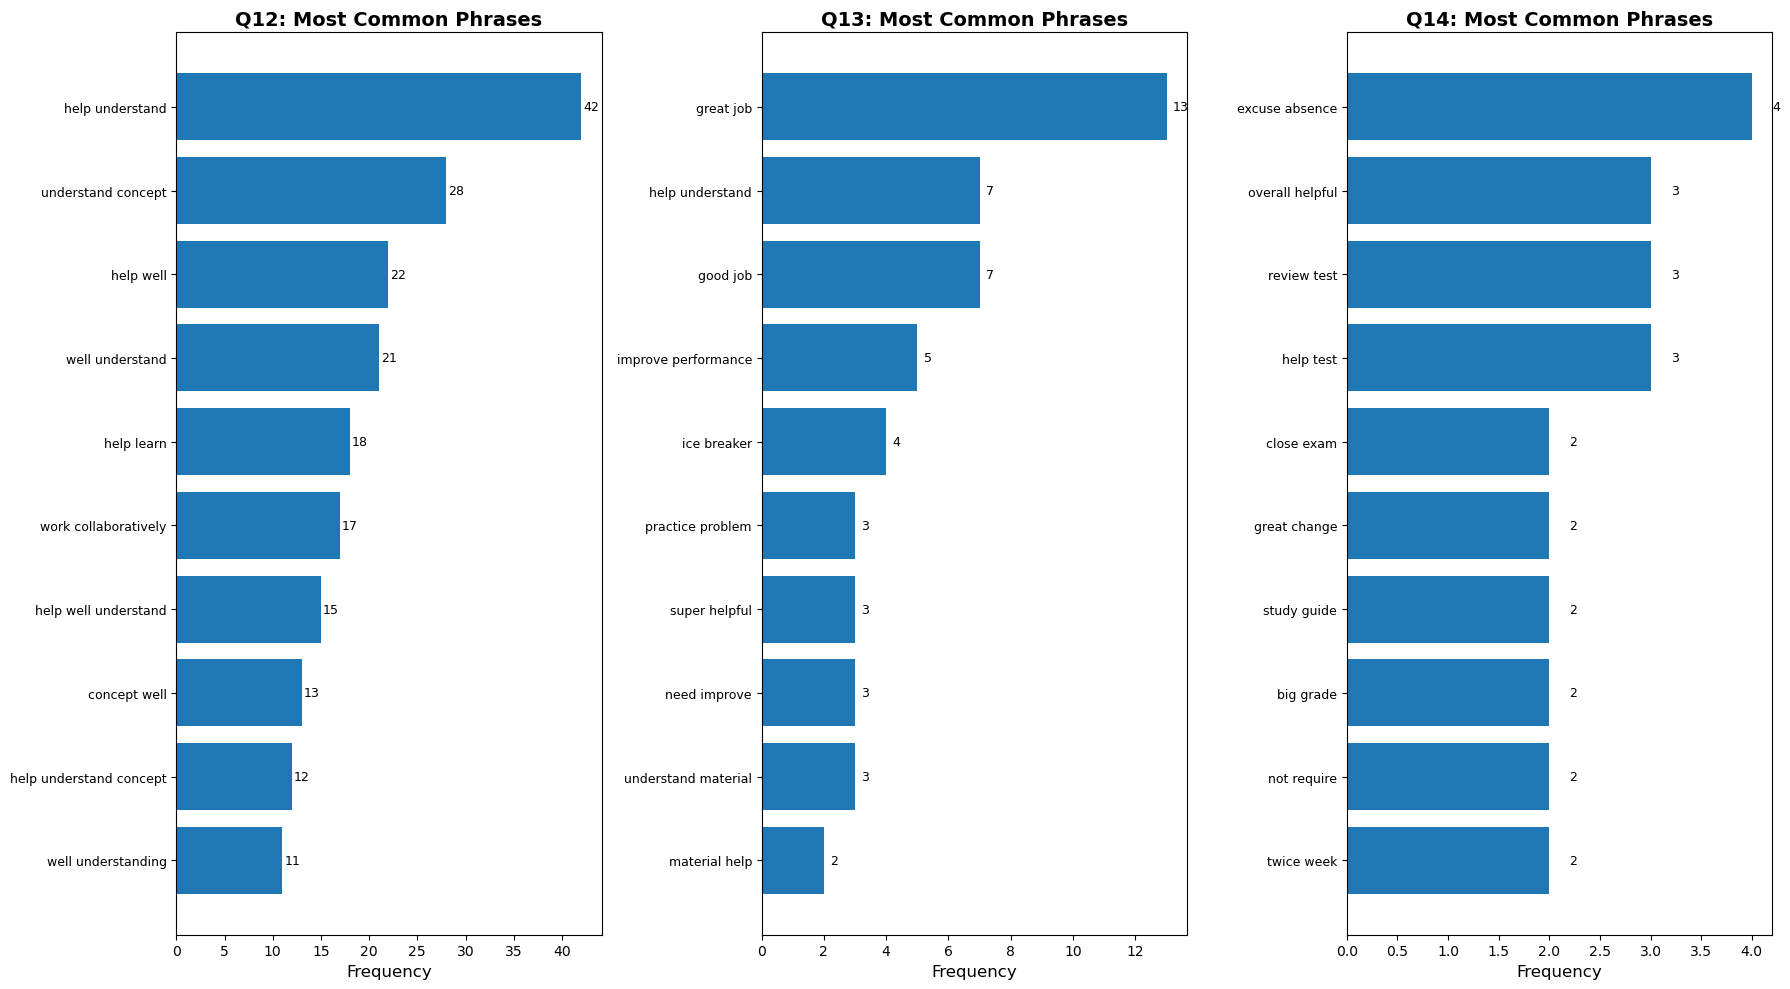

In [67]:
plot_three_questions(ngram_filtered_results)


In [70]:
theme_summary_filtered_results = create_theme_summary(df_filtered)

Theme Summaries

Q12: How has working collaboratively with your SI classmates contributed to your understanding of course concepts?
       Key Phrases  Frequency Top Concepts Descriptors
   help understand         42         help        able
understand concept         28      concept     helpful
         help well         22         work   different
   well understand         21        topic         new
        help learn         18       people     certain



Q13: What suggestions do you have for improving your leader's performance?
        Key Phrases  Frequency Top Concepts Descriptors
          great job         13   suggestion       great
    help understand          7          job        good
           good job          7         help     helpful
improve performance          5         game     amazing
        ice breaker          4  performance      little



Q14: What suggestions do you have for improving the SI Program overall?
    Key Phrases  Frequency Top Concepts Descripto

In [71]:
display(theme_summary_filtered_results)

None